In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle
import string
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Авторизация гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
# создаем датасет для проверки функций
np.random.seed(42)
n = 600
assert_data = pd.DataFrame(columns=['id', 'member_id', 'issue_d', 'target', 'test_flg', 'atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3'])
assert_data['id'] = range(n)
assert_data['member_id'] = range(n)
assert_data['issue_d'] = [datetime.datetime.strftime(datetime.date(2000,1,1) + relativedelta(months=d),'%Y-%m-%d') for d in range(60)] * int(n/60)
assert_data['target'] = [np.random.randint(2) for i in range(n)]
assert_data['test_flg'] = [np.random.randint(2) for i in range(n)]
for i in range(1, 4):
    assert_data[f'atr_int_{i}'] = np.random.random(n)
    assert_data.loc[np.random.randint(0, n, 20), f'atr_int_{i}'] = np.nan
    assert_data[f'atr_cat_{i}'] = np.random.random_integers(0, 25, n)
    assert_data.loc[np.random.randint(0, n, 20), f'atr_cat_{i}'] = np.nan


assert_tech_columns = ['id', 'member_id', 'issue_d', 'target']
assert_interrval_features = [f'atr_int_{i}' for i in range(1, 4)]
assert_category_features = [f'atr_cat_{i}' for i in range(1, 4)]
assert_features = assert_interrval_features + assert_category_features

assert_data.head()

,id,member_id,issue_d,target,test_flg,atr_int_1,atr_int_2,atr_int_3,atr_cat_1,atr_cat_2,atr_cat_3
0,0,0,2000-01-01,0,0,0.168935,0.603219,0.000135,19.0,13.0,21.0
1,1,1,2000-02-01,1,1,0.278590,0.337227,0.511129,1.0,8.0,21.0
2,2,2,2000-03-01,0,1,0.177010,0.905525,0.046852,14.0,22.0,0.0
3,3,3,2000-04-01,0,1,0.088703,0.772623,0.276170,13.0,24.0,16.0
4,4,4,2000-05-01,0,0,0.120636,0.264895,0.706976,19.0,18.0,10.0


# Загрузка датасета

Описание полей датасета в файле: LCDataDictionary.xlsx (надо отредактировать файл, возможно там есть лишние столбцы)

In [5]:
data_backup = pd.read_csv('./dataset_2_out.csv')
print(data_backup.shape)
data_backup.head(2)

(459681, 49)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,test_flg
0,1077501,1296599,5000,5000,4975.0,0,10.65,162.87,1,6,...,171.62,0.0,NaN,0,0.0,NaN,NaN,NaN,0,0
1,1077430,1314167,2500,2500,2500.0,1,15.27,59.83,2,13,...,119.66,0.0,NaN,0,0.0,NaN,NaN,NaN,1,0


In [6]:
data = data_backup.copy()

Сформируем списки технических, категориальных и интервальных атрибутов

In [7]:
# Список технических полей
tech_columns = ['id', 'member_id', 'issue_d', 'target', 'test_flg']
print(f"Количество технических атрибутов: {len(tech_columns)}")

# Список категориальных атрибутов
with open('./category_features.pickle', 'rb') as f:
    category_features = pickle.load(f)
print(f"Количество категориальных атрибутов: {len(category_features)}")

# Список интервальных атрибутов
interrval_features = list(set(data.columns) - set(tech_columns) - set(category_features))
print(f"Количество интервальных атрибутов: {len(interrval_features)}")

# Список всех атрибутов: категориальные + интервальные
features = interrval_features + category_features
print(f"Общее количество атрибутов: {len(features)}")

Количество технических атрибутов: 5
Количество категориальных атрибутов: 12
Количество интервальных атрибутов: 32
Общее количество атрибутов: 44


# Task 1. Биннинг атрибутов.

## Task 1-a
> Реализуйте функцию, которая бинаризует каждый интервальный атрибут.

> При реализации функции учтите следующее:
* Для реализации бининга воспользуйтесь pandas.qcut
* В словарь не добавляйте первую и последнюю границы, полученные функцией pandas.qcut
* Бининг производится только на заполненных наблюдениях

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. interval_attributes - список интервальных атрибутов
3. category_attributes - список категориальных атрибутов
4. num_bins - количество бинов, на которые надо разбить значения атрибутов
* Возвращает словарь, ключами которого являются названия атрибутов, а значениями список из границ бинов

In [8]:
def calc_binning(data_, interval_attributes, num_bins):
    # YOUR CODE HERE
    bins = {}
    for attr in interval_attributes:
        boundaries = []
        for boundary in pd.qcut(data_[attr], q=num_bins, precision=5, duplicates='drop').value_counts().index:
            boundaries.append(boundary.right)
        bins.update({attr: np.unique(sorted(boundaries))[:-1]})
    return bins

In [9]:
# Проверяем реализацию функции
assert_binning_dict = calc_binning(data_=assert_data[assert_data['test_flg']==0].copy(),
                                   interval_attributes=assert_interrval_features,
                                   num_bins=10
                                   )

assert len(assert_binning_dict.keys()) == 3
res = 0
res_1 = 0
res__1 = 0
for col in assert_binning_dict.keys():
    res += assert_binning_dict[col].sum()
    res_1 += assert_binning_dict[col][0]
    res__1 += assert_binning_dict[col][-1]
assert round(res, 5) == 13.09998
assert round(res_1, 5) == 0.26374
assert round(res__1, 5) == 2.66354

In [10]:
%%time
# Применяем функцию к целевой таблице
binning_dict = calc_binning(data_=data[data['test_flg']==0].copy(),
                            interval_attributes=interrval_features,
                            num_bins=10
                            )

CPU times: user 1.33 s, sys: 19.2 ms, total: 1.35 s
Wall time: 1.98 s


## Task 1-b
> Реализуйте функцию, которая по каждому значению атрибута проставляет каждому наблюдению номер группы в зависимости от значения атрибута.

> При реализации функции учтите следующее:
* Для интервальных атрибутов:
1. Бины состоят из полуинтервалов вида: '(board_X, board_Y]'
1. Если не удалось разбинить атрибут (все наблюдения попадают в один бин), то всем наблюдениям присваивается номер группы: '(-inf, +inf)'
2. Если наблюдение принадлежит первому или последнему бину, то номер группы должен выглядеть следующим образом: '(-inf, board_1]' и '(board_N, +inf)', соответственно
3. Все случаи пропсуков должны быть выделены в отдельный бин с названием 'MISSING'
* Для категориальных атрибутов: будем использовать самый простой вариант биннинга - каждое значение категориального атрибута является своим номером группы 

Имена столбцов с номерами групп должны иметь имена формата: 'GRP_col', где col - имя атрибута
Приведите номера групп в строковый формат (str).

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. interval_attributes - список интервальных атрибутов
3. category_attributes - список категориальных атрибутов
4. dict_binning - словарь бининга, полученный из предыдущей функции
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет его именами групп ('GRP_col') для каждого атрибута

In [13]:
def make_grps(data_, interval_attributes, category_attributes, dict_binning):
    data_out = data_.copy()
    for cat_col in category_attributes:
        data_out['GRP_' + str(cat_col)] = data_out[cat_col].astype(str)
        data_out.loc[:, 'GRP_' + cat_col] = data_out['GRP_' + cat_col].fillna('MISSING')
    cool_binning_dict = dict_binning.copy()
    for key in cool_binning_dict:
        l = [-np.inf]
        l.extend(list(cool_binning_dict[key]))
        l.extend([+np.inf])
        cool_binning_dict[key] = l
    for tobin_col in interval_attributes:
        ref_list = cool_binning_dict[tobin_col]
        data_out.loc[(data_out[tobin_col] >= ref_list[0]) & (data_out[tobin_col] < ref_list[1]), 'GRP_' + tobin_col] = '(-inf, ' + str(ref_list[1]) + ']'
        for idx in range(2, len(ref_list) - 1):
            data_out.loc[(data_out[tobin_col] >= ref_list[idx - 1]) & (data_out[tobin_col] < ref_list[idx]), 'GRP_' + tobin_col] = '(' + str(ref_list[idx - 1]) +', ' + str(ref_list[idx]) +']'
        data_out.loc[(data_out[tobin_col] >= ref_list[-2]) & (data_out[tobin_col] < ref_list[-1]), 'GRP_' + tobin_col] = '(' + str(ref_list[-2]) + ', +inf)'
        data_out.loc[:, 'GRP_' + tobin_col] = data_out['GRP_' + tobin_col].fillna('MISSING')
    return data_out

In [45]:
# Проверяем реализацию функции
assert_data_binned = make_grps(data_= assert_data.copy(), 
                               interval_attributes = assert_interrval_features, 
                               category_attributes = assert_category_features, 
                               dict_binning = assert_binning_dict
                               )

assert assert_data_binned.shape == (600, 17)
re1 = r"^\(\-inf, \+inf\)$"
re2 = "^\([-+]?[0-9]*[.]?[0-9]+, \+inf\)$"
re3 = "^\(\-inf, [-+]?[0-9]*[.]?[0-9]+\]$"
re4 = "^\([-+]?[0-9]*[.]?[0-9]+, [-+]?[0-9]*[.]?[0-9]+\]$"
re5 = "^MISSING$"
generic_re = re.compile("(%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5))
flg_assert = True
for i in range(1, 4):
    col = f'GRP_atr_int_{i}'
    flg_assert = flg_assert * (np.sum(assert_data_binned[col].str.fullmatch(generic_re)) == assert_data_binned.shape[0])
assert flg_assert

res_int = 0
res_cat = 0
for i in range(1, 4):
    col = f'GRP_atr_int_{i}'
    res_int += np.hstack(assert_data_binned[col].apply(lambda x: np.array(re.findall('[-+]?[0-9]*[.]?[0-9]+', x), dtype=float))).sum()
    col = f'GRP_atr_cat_{i}'
    res_cat += np.hstack(assert_data_binned[col].apply(lambda x: np.array(re.findall('[-+]?[0-9]*[.]?[0-9]+', x), dtype=float))).sum()

print(round(res_int, 5))
assert round(res_int, 5) == 1530.37743
assert round(res_cat, 5) == 22074.0

#Тут небольшое расхождение

1530.48218


AssertionError: ignored

In [15]:
%%time
# Применяем функцию к целевой таблице
data_binned = make_grps(data_=data.copy(), 
                        interval_attributes=interrval_features, 
                        category_attributes=category_features, 
                        dict_binning=binning_dict
                        )

CPU times: user 9.96 s, sys: 607 ms, total: 10.6 s
Wall time: 12 s


#Task 2. Вычисление значение WOE-факторов

## Task 2-a
> Реализуйте функцию, которая вычисляет значение WOE-фактора для каждого бина каждого атрибута.

> Если атрибут разбит на n категорий, то для категории i WOE рассчитывается по следующей формуле:
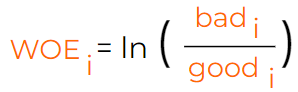
* bad_i - доля всех плохих клиентов (целевое событие 1), которая попадает в группу i
* good_i - доля всех плохих клиентов (целевое событие 0), которая попадает в группу i

> При реализации функции учтите следующее:
* При необходимости, чтобы избежать NAN в качестве значения WOE, замените все пропуски при вычислении на 0.00001.

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. attributes_ - список атрибутов
3. target_name - имя колонки с целевым событием
* Возвращает словарь, ключами которого являются названия атрибутов, а значениями pandas.DataFrame со столбцами: GRP_col и WOE_col, где col - имя атрибута



In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 325 kB/s 


In [19]:
import category_encoders

In [38]:
def calc_woe(data_, attributes_, target_name):
    eps = 0.00001
    res_dict = {}
    for col in attributes_:
        df = data_[['GRP_'+str(col), target_name]]
        val_counts = df.groupby(target_name)['GRP_'+col].value_counts()
        
        bad = val_counts[1]/df[target_name].value_counts()[1]
        good = val_counts[0]/df[target_name].value_counts()[0]
        bad_good = pd.concat([good.rename('good'), bad.rename('bad')], axis=1).fillna(eps)
        
        res_df = np.log(bad_good['bad']/bad_good['good']) * -1
        
        res_df = res_df.fillna(eps)
        res_df = res_df.to_frame('WOE_'+col).reset_index()
        res_dict[str(col)] = res_df

    return res_dict

In [39]:
# Проверяем реализацию функции
assert_woe_dict = calc_woe(data_= assert_data_binned[assert_data_binned['test_flg']==0], attributes_ = assert_features, target_name='target')

assert len(assert_woe_dict.keys()) == 6
res = 0
for col in assert_woe_dict.keys():
    res += np.array(assert_woe_dict[col].shape)
assert set(res) == {12, 114}

In [40]:
%%time
# Применяем функцию к целевой таблице
woe_dict = calc_woe(data_=data_binned[data_binned['test_flg']==0], attributes_=features, target_name='target')

CPU times: user 3.06 s, sys: 33.9 ms, total: 3.09 s
Wall time: 3.08 s


## Task 2-b
> Реализуйте функцию, которая каждому наблюдению присоединяет значение WOE в зависимости от значения атрибута.

> При реализации функции учтите следующее:
* При необходимости, чтобы избежать NAN в столбцах со значениями WOE, замените все пропуски на 0.

Имена столбцов со значением WOE должны иметь имена формата: 'WOE_col', где col - имя атрибута

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. attributes_ - список атрибутов
3. dict_woe - словарь со значениями WOE из предыдущей функции
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет его значениями WOE ('WOE_col') для каждого атрибута

In [41]:
def merge_woe(data_, attributes_, dict_woe):
    for col in attributes_:
        woes = dict_woe[col]
        data_ = data_.merge(woes, on='GRP_'+str(col) )
    return data_ 

In [44]:
# Проверяем реализацию функции
assert_data_binned_woe = merge_woe(data_ = assert_data_binned.copy(), attributes_ = assert_features, dict_woe = assert_woe_dict)

assert assert_data_binned_woe.shape == (600, 23)
woe_sum = [6.41035, 10.09985, -8.87265, -47.36889, -114.97994, 7.88363]
for i, col in enumerate(['int_1', 'int_2', 'int_3', 'cat_1', 'cat_2', 'cat_3']):
    assert round(assert_data_binned_woe[f'WOE_atr_{col}'].sum(), 5) == woe_sum[i]

In [ ]:
%%time
# Применяем функцию к целевой таблице
data_binned_woe = merge_woe(data_=data_binned.copy(), attributes_=features, dict_woe=woe_dict)

# Task 3. Однофакторный анализ

> Реализуйте функцию формирования однофакторного анализа, для каждого атрибута вычисляет следующие характеристики данного атрибута:
* Коэффициент Джини на train выборке
* Коэффициент Джини на test выборке
* Значение PSI 

> При реализации функции учтите следующее:
* Коэффициент Джини можно вычислить, как 2*roc_auc_score-1
* PSI вычисляется по формуле: 
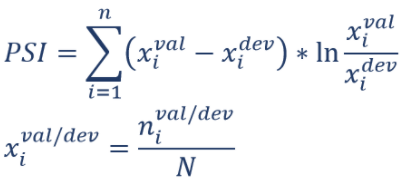
* n_i - количество наблюдений в группе i на выборке для разработки (dev) или тестирования (val)
* N - число наблюдений в выборке для разработки или тестировании (dev или val)

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми столбцами
2. attributes_ - список атрибутов
3. target_name - имя целевого события
4. test_flg_name - имя столбца с флагом тестовой выборки
* Возвращает pandas.DataFrame со следующими полями:
1. Attribute - имя атрибута
2. GINI test - коэффициент Джини на test выборке
3. GINI train - коэффициент Джини на Train выборке
4. GINI delta - относительное изменение коэффициента Джини на test по сравнению с train
5. PSI - значение PSI для атрибута


In [ ]:
def one_factor_analyses_function(data_, attributes_, target_name, test_flg_name):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_one_factor_analyses = one_factor_analyses_function(data_ = assert_data_binned_woe.copy(), 
                                                   attributes_ = assert_features, 
                                                   target_name = 'target', 
                                                   test_flg_name = 'test_flg'
                                                   )

assert assert_one_factor_analyses.shape == (6, 5)
assert set(assert_one_factor_analyses.columns) == {'Attribute', 'GINI test', 'GINI train', 'GINI delta', 'PSI'}
assert round(assert_one_factor_analyses['GINI train'].sum(), 5) == 1.6008
assert round(assert_one_factor_analyses['GINI test'].sum(), 5) == 0.286
assert round(assert_one_factor_analyses['GINI delta'].sum(), 5) == -4.7197
assert round(assert_one_factor_analyses['PSI'].sum(), 5) == 0.9109

In [ ]:
%%time
# Применяем функцию к целевой таблице
one_factor_analyses = one_factor_analyses_function(data_=data_binned_woe.copy(), 
                                                   attributes_=features, 
                                                   target_name='target', 
                                                   test_flg_name='test_flg'
                                                   )

Выведем результаты однофакторного анализа, отсортированные по убыванию коэффициента Джини на train выборке

In [ ]:
one_factor_analyses.sort_values('GINI train', ascending=False)

# Task 4. Многофакторный анализ

Сформируем длинный список "хороших" атрибутов:
* Отбираем атрибуты, удовлетворяющие условиям на величину коэффициентов, вычисленных на этапе однофакторного анализа
* Сортируем список атрибутов по уменьшению GINI на train выборке

In [ ]:
good_features_long = list(one_factor_analyses[(one_factor_analyses['GINI train'] > 0.05)
                                               & (abs(one_factor_analyses['GINI delta']) < 0.50)
                                               & (one_factor_analyses['PSI'] < 0.20)
                                             ].sort_values('GINI train', ascending=False)['Attribute'])

print(f'Number of good features: {len(good_features_long)}')

Также для отбора атрибутов можно использовать встренные в sklearn методы, которые основаны на статистическом отборе признаков по их влиянию на целевую переменную

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2, f_classif , mutual_info_classif 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train = data_binned_woe[data_binned_woe['test_flg']==0]
X_test  = data_binned_woe[data_binned_woe['test_flg']==1]
X_train[interrval_features] = X_train[interrval_features].fillna(X_train[interrval_features].mean())
X_test[interrval_features] = X_test[interrval_features].fillna(X_train[interrval_features].mean())

scaler = MinMaxScaler()
X_train.loc[:, interrval_features] = scaler.fit_transform(X_train[interrval_features])
X_test.loc[:, interrval_features]  = scaler.transform(X_test[interrval_features])

In [ ]:
selector = SelectKBest(k=10, score_func=chi2)
selector.fit(X_train[interrval_features], X_train['target'])

# Список отобранных атрибутов
selector.get_feature_names_out()

In [ ]:
estimator = LogisticRegression()
recursive_selector = RFE(estimator, n_features_to_select=10)
recursive_selector.fit(X_train[interrval_features], X_train['target'])

# Список отобранных атрибутов
recursive_selector.get_feature_names_out()

Построим и отобразим матрицу корреляций Спирмена для длинного списка "хороших" атрибутов

In [ ]:
corr_matrix = data_binned_woe[data_binned_woe['test_flg']==0][['WOE_'+col for col in good_features_long]].corr(method='spearman')
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

> Реализуйте функцию отбора короткого списка "хороших" атрибутов на основе корреляции атрибутов.

> Алгоритм отбора признаков следующий:
* Все признаки сортируются по уменьшению коэффициента Джини на train выборке
* Затем они поочередно добавляются в новый список, если не коррелируют с другими атрибутами из этого списка
* Атрибуты считаются скоррелированными, если коэффициент корреляции >= 50%

> Описание функции:
* На вход принимает:
1. features_list - длинный список атрибутов
2. corr - матрицу корреляций для длинного списка атрибутов
* Возвращает короткий список "хороших" атрибутов

In [ ]:
def filter_uncorrelated_features(features_list, corr):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_corr_matrix = assert_data_binned_woe[assert_data_binned_woe['test_flg']==0][['WOE_'+col for col in assert_features]].corr()
assert_good_features_short = filter_uncorrelated_features(features_list = assert_features, corr = assert_corr_matrix)
print(f'Количество хороших некоррелирующих атрибутов: {len(assert_good_features_short)}')

assert len(assert_good_features_short) == 6
temp_corr = assert_corr_matrix.reset_index()
temp_corr = temp_corr[temp_corr['index'].isin(['WOE_'+col for col in assert_features])][['index']+['WOE_'+col for col in assert_features]].set_index('index')
assert np.sum(temp_corr.values<0.1) == 18
assert round(np.sum(temp_corr.values), 5) == 7.50577

In [ ]:
# Применяем функцию к целевой таблице
good_features_short = filter_uncorrelated_features(features_list=good_features_long, corr=corr_matrix)
print(f'Количество хороших некоррелирующих атрибутов: {len(good_features_short)}')

Отобразим однофакторный анализ короткого "хорошего" списка атрибутов

In [ ]:
one_factor_analyses[one_factor_analyses['Attribute'].isin(good_features_short)].sort_values('GINI train', ascending=False)

Построим и отобразим матрицу корреляций Пирсона для короткого списка "хороших" атрибутов, из результатов видно, что корреляция не превышает порог в 50%

In [ ]:
temp_corr = corr_matrix.reset_index()
temp_corr = temp_corr[temp_corr['index'].isin(['WOE_'+col for col in good_features_short])][['index']+['WOE_'+col for col in good_features_short]].set_index('index')
temp_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Отобразим биннинг атрибутов из хорошего короткого списка атрибутов (good_features_short)

In [ ]:
# Печатаем Биннинг
def print_binning(data, interval_attributes, category_attributes, target, test_flg_name, figsize=(16,8), h_pt=16):
    
    for i, col in enumerate(interval_attributes+category_attributes):
        
#         clear_output(wait=True)
        print(f'Column {i+1}/{len(interval_attributes+category_attributes)}')
        print(col)
        
        
        temp = data.groupby([test_flg_name, col]).agg({target : ['count', 'sum']}).reset_index().sort_values(col)
        temp.columns = [test_flg_name, col, 'cnt', 'def_cnt']
        temp['def_rate'] = temp['def_cnt'] / temp['cnt']
        temp = temp.merge(data.groupby(test_flg_name).agg({target : 'count'}).reset_index(), on=[test_flg_name], how='left')
        temp['pop_rate'] = temp['cnt'] / temp[target]
        temp = temp.drop(columns=[target])
        
        if col in interval_attributes:
            temp['sort_col'] = temp[col].apply(lambda x: np.inf if 'MISSING' in x else float(x[1:-1].split(',')[0]) if x[1:-1].split(',')[0] != '-inf' else -np.inf)
        elif col in category_attributes:
            temp['sort_col'] = temp[col].apply(lambda x: np.inf if 'MISSING' in x else float(x))
        temp = temp.sort_values([test_flg_name, 'sort_col'])
        temp = temp.drop(columns=['sort_col'])
        temp_tr = temp[temp[test_flg_name]==0]
        temp_ts = temp[temp[test_flg_name]==1]
    
        fig, ax1 = plt.subplots(figsize=figsize)
        color = 'tab:blue'
        h_pt = h_pt
        col_name = col.replace('GRP_','')
        ax1.set_title('Распределение доли популяции и уровня дефолта по группам фактора\n'+col_name, fontsize=h_pt)
        ax1.set_xlabel('Группы фактора ' + col_name, fontsize=h_pt)
        ax1.set_ylabel('Доля популяции', fontsize=h_pt)

        plt.bar(temp_tr[col], temp_tr['pop_rate'], align='edge', width=-0.4, edgecolor='black', color=color, label='train')
        plt.bar(temp_ts[col], temp_ts['pop_rate'], align='edge', width=0.4, edgecolor='black', color='lightblue', label='test')
        plt.legend(loc='upper left')

        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Уровень дефолта', fontsize=h_pt)

        plt.plot(temp_tr[col], temp_tr['def_rate'], '+-r', linewidth=5, markersize=20, label='train') 
        plt.plot(temp_ts[col], temp_ts['def_rate'], '+-g', linewidth=5, markersize=20, label='test') 
        plt.legend(loc='upper right')

        ax2.tick_params('y')
        fig.tight_layout()

        plt.show()


        # Печатаем расчетную таблицу
        with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
            print(temp)

In [ ]:
interrval_features_short = [col for col in good_features_short if col in interrval_features]
category_features_short = [col for col in good_features_short if col in category_features]
print_binning(data=data_binned_woe.copy(), 
              interval_attributes=[f'GRP_{col}' for col in interrval_features_short], 
              category_attributes=[f'GRP_{col}' for col in category_features_short], 
              target='target',
              test_flg_name = 'test_flg'
              )

# Task 4. Построение модели логистической регресси на WOE факторах



Пострим модель логисчтической регресси на WOE факторах короткого списка "хороших" атрибутов. 

* Какое получается качество? 
* Чему равен коэффициент Джини на train и test выборках?
* За счет чего можно улучшить качество?
* Проверьте интерпретируемость модели и соответствие атрибутов бизнес смыслу

In [ ]:
X_train = data_binned_woe[data_binned_woe['test_flg']==0][['WOE_'+col for col in good_features_short]]
y_train = data_binned_woe[data_binned_woe['test_flg']==0]['target']
X_test = data_binned_woe[data_binned_woe['test_flg']==1][['WOE_'+col for col in good_features_short]]
y_test = data_binned_woe[data_binned_woe['test_flg']==1]['target']

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

pred_train = logreg.predict_proba(X_train)[:, 1]
pred_test = logreg.predict_proba(X_test)[:, 1]

print(f'GINI train: {round(2*roc_auc_score(y_train, pred_train)-1, 4)}')
print(f'GINI test: {round(2*roc_auc_score(y_test, pred_test)-1, 4)}')

**Ответ:**

Проскорим train и test выборки и сохраним значения вероятностей дефолта

In [ ]:
data_binned_woe['PD'] = logreg.predict_proba(data_binned_woe[['WOE_'+col for col in good_features_short]])[:, 1]

# Task 5. Построение скоринговой карты

> Реализуйте функцию построения скоринговой карты.

> При реализации функции учтите следующее:
* 600 - значение на шкале баллов, в которой соотношение шансов составляет С:1
* С = 72
* 40 — количество баллов, удваивающее шансы
* Полученное значение скорингового балла следует округлить до целого

> Описание функции:
* На вход принимает:
1. model - построенная модель логистической регрессии
2. features_short - список атрибутов, на котором построена логистическая регрессия
3. woe_dict_ - словарь со значениями WOE факторов по группам
* Возвращает pandas.DataFrame со следующими полями:
1. ATTRIBUTE - название атрибута
2. GRP - номер ("имя") группы
3. WOE - значение WOE фактора для группы
4. SCORE - величина скорингового балла для данной группы

In [ ]:
def build_scorecard(model, features_short, woe_dict_):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_logreg = LogisticRegression(random_state=42).fit(assert_data_binned_woe[[f"WOE_{col}" for col in assert_good_features_short]], assert_data_binned_woe['target'])
assert_scorecard = build_scorecard(model = assert_logreg, 
                                   features_short = assert_good_features_short, 
                                   woe_dict_ = assert_woe_dict
                                   )

assert assert_scorecard.shape == (114, 4)
assert set(assert_scorecard.columns) == {'ATTRIBUTE', 'GRP', 'SCORE', 'WOE'}
assert round(assert_scorecard['WOE'].sum(), 5) == -10.47859
assert round(assert_scorecard['SCORE'].sum(), 5) == 6510.0

In [ ]:
scorecard = build_scorecard(model=logreg, 
                            features_short=good_features_short, 
                            woe_dict_=woe_dict
                            )

In [ ]:
pd.set_option('display.max_rows', 100)
scorecard.set_index(['ATTRIBUTE', 'GRP'])

Присвоим каждому наблюдению скорбалл в зависимости от значения атрибута, а так же финальный скоринговый балл

In [ ]:
%%time
data_binned_woe['SCORE'] = 0
for col in scorecard['ATTRIBUTE'].drop_duplicates():
    temp_score = scorecard[scorecard['ATTRIBUTE']==col].copy()
    temp_score = temp_score.rename(columns={'SCORE':'SCORE_'+col, 'GRP':'GRP_'+col})
    data_binned_woe = data_binned_woe.merge(temp_score[['GRP_'+col, 'SCORE_'+col]], on='GRP_'+col, how='left')
    data_binned_woe['SCORE'] = data_binned_woe['SCORE'] + data_binned_woe['SCORE_'+col]

# Сохранение результатов

Сохраняем обученную модель, короткий список "хороших" атрибутов, проскоренную выборку для дальнейшего использования

In [ ]:
%%time
# сохраняем обученную модель
with open('./model_logreg_woe.pickle', 'wb') as f:
    pickle.dump(logreg, f)
    
# сохраняем список атрибутов
with open('./attributes_logreg_woe.pickle', 'wb') as f:
    pickle.dump(good_features_short, f)
    
# сохраняем выборку
data_binned_woe.to_csv('./data_grp_woe_pd_score.csv', index=False)